# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)

In [6]:
# Intstall PyTorch and download data
# !pip3 install torch torchvision

# !wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2023-01-10 17:31:23--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173,61M  3,08MB/s    in 3m 28s  

2023-01-10 17:34:53 (854 KB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2023-01-10 17:34:53--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61,30M  5,25MB/s    in 15s     

2023-01-10 17:35:09 (3,96 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2023-01-10 17:35:09--
Total wall clock time: 3m 46s
Downloaded: 2 files, 235M 

In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

torch.manual_seed(0)

In [2]:
device = torch.device("cuda:0") # Let's make sure GPU is available!
print(torch.cuda.get_device_name(0))


NVIDIA GeForce GTX 1660 Ti


### Загружаем данные

In [3]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))



Теперь мы разделим данные на training и validation с использованием классов SubsetRandomSampler и DataLoader.

DataLoader подгружает данные, предоставляемые классом Dataset, во время тренировки и группирует их в батчи. Он дает возможность указать Sampler, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [5]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - nn.Conv2d  
MaxPool - nn.MaxPool2d

In [6]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

#             nn.BatchNorm1d(100),
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

torch.manual_seed(0)
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
# optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-4 )
scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma= 0.98)



Восстановите функцию compute_accuracy из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция train_model

In [7]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, sheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        if not scheduler is None:
            scheduler.step()
        
        print("Epoch: %i, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    
    model.eval()  # Evaluation mode
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        # count = i_step
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        predictions = model(x_gpu)
        pred = torch.argmax(predictions, axis=1)
        correct_samples += torch.sum(pred == y_gpu)
        total_samples += y.shape[0]

    val_accuracy = float(correct_samples) / total_samples
    # print("val accuracy is ", val_accuracy)
    return val_accuracy
    
     # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)


/home/arseniy/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0, Average loss: 1.065009, Train accuracy: 0.673532, Val accuracy: 0.797898
Epoch: 1, Average loss: 0.609282, Train accuracy: 0.828721, Val accuracy: 0.834892
Epoch: 2, Average loss: 0.522464, Train accuracy: 0.853377, Val accuracy: 0.852297
Epoch: 3, Average loss: 0.473189, Train accuracy: 0.867454, Val accuracy: 0.857962
Epoch: 4, Average loss: 0.441148, Train accuracy: 0.874927, Val accuracy: 0.857621


### Проверяю скорость выполнения CNN в случае работы на CPU

In [22]:
# import TorchTrainer as trainer
# # device = torch.device("cpu")
# torch.set_default_tensor_type(torch.FloatTensor)

# nn_model = nn.Sequential(
#             nn.Conv2d(3, 64, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(4),
#             nn.Conv2d(64, 64, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(4),    
#             Flattener(),
#             nn.Linear(64*2*2, 10),
#           # 

# nn_model.type(torch.FloatTensor)
# # nn_model.to(device)

# loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
# optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

# # print(torch.cuda.get_device_name(0))




In [23]:
# loss_history, train_history, val_history = trainer.train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)


Epoch: 0, Average loss: 1.325363, Train accuracy: 0.560540, Val accuracy: 0.767183
Epoch: 1, Average loss: 0.681514, Train accuracy: 0.792786, Val accuracy: 0.806088
Epoch: 2, Average loss: 0.579059, Train accuracy: 0.824898, Val accuracy: 0.829704
Epoch: 3, Average loss: 0.536610, Train accuracy: 0.840784, Val accuracy: 0.821650
Epoch: 4, Average loss: 0.508114, Train accuracy: 0.848838, Val accuracy: 0.841376


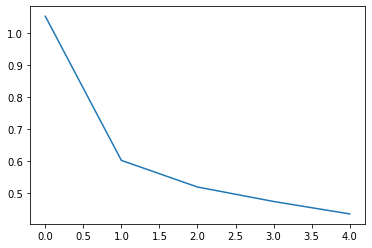

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

predictions
 tensor([2, 2, 5, 5, 1, 3, 3, 6, 7, 8], device='cuda:0')
labels
 tensor([2, 2, 3, 5, 1, 3, 3, 6, 7, 8])


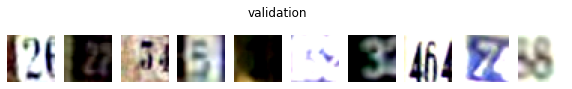

In [11]:
import TorchTrainer as trainer                      
images, labels = next(iter(val_loader))

x_gpu = images.to(device)
# y_gpu = y.to(device)

preds = nn_model(x_gpu)
preds = torch.argmax(preds, axis=1)
number = 10

plt.plot(loss_history)
plt.show()

fig = plt.figure(figsize=(10,1.5))
fig.suptitle("validation")

for i in range(number):
        plt.subplot(1,number, i+1)
        plt.axis('off')
        img = (images[i]+1)/2
        # npimg = img.numpy()
        # plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.imshow(  img.permute(1, 2, 0)  )

print("predictions\n", preds[:10])
print("labels\n", labels[:10])

In [ ]:
# nn_model = nn.Sequential(
#             Flattener(),
#             nn.Linear(3*32*32, 100),
#             nn.BatchNorm1d(100),
#             nn.ReLU(inplace=True),
#             nn.Linear(100, 100),
#             nn.BatchNorm1d(100),
#             nn.ReLU(inplace=True),
#             nn.Linear(100, 10), 
#          )
# nn_model.type(torch.FloatTensor)

# num_epochs = 13
# loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
# optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-5)
# scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma= 0.93)
# loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler)


### Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети. Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых transforms. Более подробно про них можно прочитать тут - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:

ColorJitter - случайное изменение цвета  
RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%  
RandomVerticalFlip - вертикальное отражение с вероятностью 50%  
RandomRotation - случайный поворот  

In [12]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])



# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/home/arseniy/.local/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1230: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

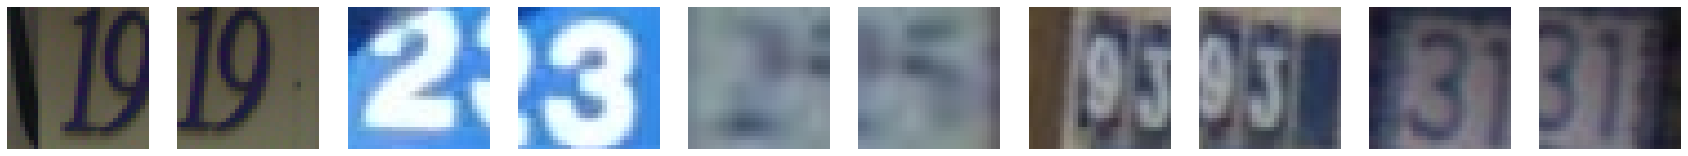

In [47]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.43,0.44,0.47],
    #                    std=[0.20,0.20,0.20]) 
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )



plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x.permute(1, 2, 0))
    plt.axis('off')

## x.permute(1, 2, 0)

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [8]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.43,0.44,0.47],
    #                    std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', transform=tfs)
                      
data_val = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                        #    transforms.Normalize(mean=[0.43,0.44,0.47],
                        #                        std=[0.20,0.20,0.20])                           
                       ]))

                                        
batch_size = 64

train_size = data_train.data.shape[0]
val_size = data_val.data.shape[0]

train_indices = list(range(train_size))
val_indices = list(range(val_size))

# train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)


train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size,
                                         sampler=val_sampler)
# TODO create new instances of loaders with the augmentations you chose
# train_aug_loader = None

/home/arseniy/.local/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1230: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


In [9]:

# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Epoch: 0, Average loss: 0.570919, Train accuracy: 0.834801, Val accuracy: 0.854717
Epoch: 1, Average loss: 0.506660, Train accuracy: 0.853161, Val accuracy: 0.868623
Epoch: 2, Average loss: 0.482302, Train accuracy: 0.861856, Val accuracy: 0.864474
Epoch: 3, Average loss: 0.463457, Train accuracy: 0.868040, Val accuracy: 0.876998
Epoch: 4, Average loss: 0.451022, Train accuracy: 0.869391, Val accuracy: 0.875230


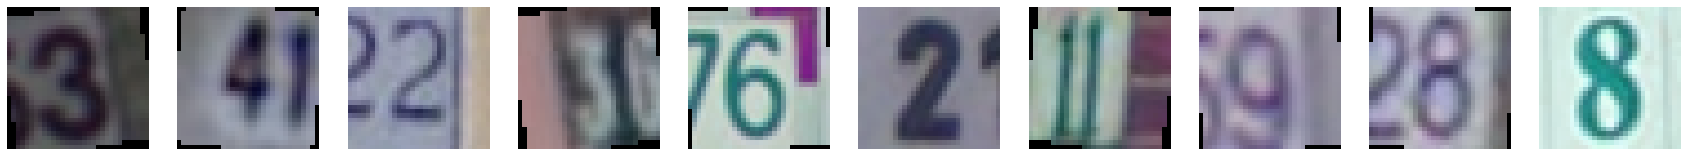

In [52]:
plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(train_aug_loader):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x[i].permute(1, 2, 0))
    plt.axis('off')

### LeNet

Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN? Она описана в статье "Gradient Based Learning Applied to Document Recognition", попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, не нужно - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [61]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    # transforms.ColorJitter(hue=.20, saturation=.20),
    # transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.43,0.44,0.47],
    #                    std=[0.20,0.20,0.20])                           
])


torch.manual_seed(0)

# Create augmented train dataset
data_aug_train = dset.SVHN('./', transform=tfs)
                      
data_val = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                        #    transforms.Normalize(mean=[0.43,0.44,0.47],
                        #                        std=[0.20,0.20,0.20])                           
                       ]))

                                        
batch_size = 32

train_size = data_train.data.shape[0]
val_size = data_val.data.shape[0]

train_indices = list(range(train_size))
val_indices = list(range(val_size))

# train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)


train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size,
                                         sampler=val_sampler)
# TODO create new instances of loaders with the augmentations you chose
# train_aug_loader = None

In [62]:

# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
            Flattener(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
          )

# # parameters
# RANDOM_SEED = 42
# LEARNING_RATE = 0.001
# BATCH_SIZE = 32
# N_EPOCHS = 15

# IMG_SIZE = 32
# N_CLASSES = 10

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(lenet_model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 15)

Epoch: 0, Average loss: 1.579599, Train accuracy: 0.460461, Val accuracy: 0.762446
Epoch: 1, Average loss: 0.589925, Train accuracy: 0.820413, Val accuracy: 0.816303
Epoch: 2, Average loss: 0.480649, Train accuracy: 0.855167, Val accuracy: 0.831822


KeyboardInterrupt: 

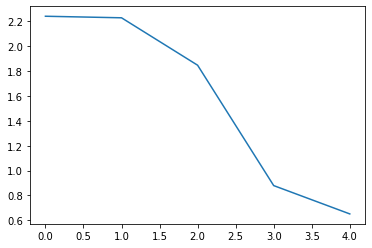

predictions
 tensor([6, 1, 2, 5, 8, 9, 3, 4, 6, 1], device='cuda:0')
labels
 tensor([2, 1, 2, 5, 8, 9, 3, 6, 6, 1])


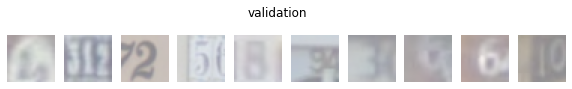

In [58]:
import TorchTrainer as trainer                      
images, labels = next(iter(val_loader))

x_gpu = images.to(device)
# y_gpu = y.to(device)

preds = nn_model(x_gpu)
preds = torch.argmax(preds, axis=1)
number = 10

plt.plot(loss_history)
plt.show()

fig = plt.figure(figsize=(10,1.5))
fig.suptitle("validation")

for i in range(number):
        plt.subplot(1,number, i+1)
        plt.axis('off')
        img = (images[i]+1)/2
        # npimg = img.numpy()
        # plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.imshow(  img.permute(1, 2, 0)  )

print("predictions\n", preds[:10])
print("labels\n", labels[:10])